In [30]:
!pip install yfinance

In [15]:
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [69]:
ticker='AAPL'
start_D="2018-01-01"
end_D="2025-04-30"

data=yf.download(ticker,start=start_D,end=end_D)

series=data["Close"].dropna()
print(series.head())

[*********************100%***********************]  1 of 1 completed

Ticker           AAPL
Date                 
2018-01-02  40.479843
2018-01-03  40.472786
2018-01-04  40.660786
2018-01-05  41.123714
2018-01-08  40.970978


In [89]:
# 슬라이딩 윈도우로 (X, Y) 시퀀스를 만드는 함수
def MMDD(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i : i + seq_len])
        y.append(data[i + seq_len])
    x = np.array(x)[:, :, None]
    y = np.array(y)[:, None]
    print("Shape of NumPy array X:", X.shape) # <--- 확인
    print("Shape of NumPy array y:", y.shape) 
    return (
        torch.tensor(x, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32).reshape(-1,1),
    )

In [92]:
def MMDD(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i : i + seq_len])
        y.append(data[i + seq_len])
    x = np.array(x)[:, :, None]  # shape: (N, seq_len, 1)
    y = np.array(y)[:, None]    # shape: (N, 1)
    return (
        torch.tensor(x, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32),
    )

In [94]:
#정규화 (Min–Max)
min_val, max_val=series.min(), series.max()
series_norm=(series-min_val)/(max_val-min_val)

#표준화
#mean, std=series.mean(), series.std()
#series_std=(series-mean)/std
arr = series_norm.values

#슬라이딩 윈도우 생성
seq_len=12
x,y=MMDD(arr, seq_len)


ds     = TensorDataset(x, y)
loader = DataLoader(ds, batch_size=16, shuffle=True)


In [96]:
class Model(nn.Module):
    def __init__(self, input:int=1, hidden:int=64, num_layer:int=2, dropout:float=0.3):
        super().__init__()  # 또는 super(Model, self).__init__()

        self.lstm = nn.LSTM(
            input,hidden,
            num_layers=num_layer,
            batch_first=True,
            dropout=dropout if num_layer>1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc= nn.Linear(hidden, 1)


    def forward(self, x):
        out,_=self.lstm(x)
        last=out[:,-1,:]
        feat=self.dropout(last)
        return self.fc(feat)

In [98]:
device=torch.cuda.is_available()
print(device)
model=Model()
num_epoch=10
criter=nn.MSELoss()
optimy=optim.Adam(model.parameters(), lr=1e-4)
train_losses = []


False


In [100]:
def init_weight(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.LSTM, nn.GRU)):
        for name, p in m.named_parameters():
            if 'weight_hh' in name:
                nn.init.orthogonal_(p)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(p)
            elif 'bias' in name:
                nn.init.zeros_(p)
model.apply(init_weight)

Model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [103]:
model.train()
for epoch in range(num_epoch):
    total_L = 0.0
    for data, target in loader:
        #print("Input batch shape before reshape:", data.shape) # 추가: 원래 형태 확인
        # 명시적으로 3차원으로 형태 변경 (batch_size, seq_len, input_size)
        data = data.view(data.size(0), seq_len, -1)  #이거안하면 4차원으로 인식되서 에러남(이놈떔시 5시간을 뺑이쳤다. ㅈ같다.ㅆㅂ)
        #print("Input batch shape after reshape:", data.shape) # 추가: 변경된 형태 확인
        optimy.zero_grad()
        out   = model(data)
        loss  = criter(out, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimy.step()
        total_L += loss.item() * data.size(0)

    avg_loss = total_L / len(loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epoch}  Train MSE: {avg_loss:.6f}")

C:\Users\JH\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JH\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5, 1, 1])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10  Train MSE: 0.147472
Epoch 2/10  Train MSE: 0.080496
Epoch 3/10  Train MSE: 0.078157
Epoch 4/10  Train MSE: 0.076726
Epoch 5/10  Train MSE: 0.076407
Epoch 6/10  Train MSE: 0.076295
Epoch 7/10  Train MSE: 0.076412
Epoch 8/10  Train MSE: 0.076551
Epoch 9/10  Train MSE: 0.076443
Epoch 10/10  Train MSE: 0.076821


[*********************100%***********************]  1 of 1 completed


Shape of series_norm: (1841, 1)
Epoch 1/10  Train MSE: 0.124127
Epoch 2/10  Train MSE: 0.012553
Epoch 3/10  Train MSE: 0.005625
Epoch 4/10  Train MSE: 0.005051
Epoch 5/10  Train MSE: 0.003996
Epoch 6/10  Train MSE: 0.004078
Epoch 7/10  Train MSE: 0.003527
Epoch 8/10  Train MSE: 0.003646
Epoch 9/10  Train MSE: 0.003472
Epoch 10/10  Train MSE: 0.003027


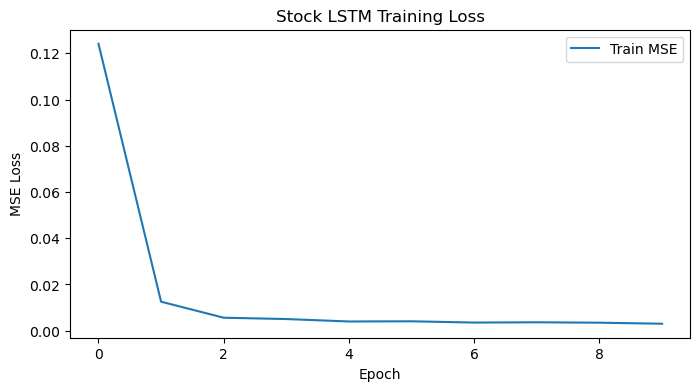

In [117]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 1. Download historical stock data
ticker   = 'AAPL'
start_D  = '2018-01-01'
end_D    = '2025-04-30'
data     = yf.download(ticker, start=start_D, end=end_D)
series   = data['Close'].dropna()

# 2. Min–Max normalization
min_val   = series.min()
max_val   = series.max()
series_nm = (series - min_val) / (max_val - min_val)
arr = series_nm.values.reshape(-1, 1)
print("Shape of series_norm:", arr.shape)
# 3. Create sliding-window sequences
'''
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i : i + seq_len])
        y.append(data[i + seq_len])
    x = np.array(x)[:, :, None]
    y = np.array(y)[:, None]
    #print("Shape of NumPy array X:", X.shape) # <--- 확인
    #print("Shape of NumPy array y:", y.shape) 
    return (
        torch.tensor(x, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32).reshape(-1,1),
    )
'''
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i : i + seq_len])
        y.append(data[i + seq_len])
    x = np.array(x).reshape(-1, seq_len, 1) # 명시적으로 3차원으로 reshape
    y = np.array(y).reshape(-1, 1)       # 명시적으로 2차원으로 reshape
    return (
        torch.tensor(x, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32),
    )

seq_len = 12
X, Y    = create_sequences(arr, seq_len)

# 4. Dataset and DataLoader
dataset = TensorDataset(X, Y)
loader  = DataLoader(dataset, batch_size=16, shuffle=True)

# 5. Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # out: (batch, seq_len, hidden_size)
        last    = out[:, -1, :]       # take last time-step
        feat    = self.dropout(last)
        return self.fc(feat)          # (batch, 1)

model = StockLSTM()

# 6. Weight initialization
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.LSTM, nn.GRU)):
        for name, p in m.named_parameters():
            if 'weight_hh' in name:
                nn.init.orthogonal_(p)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(p)
            elif 'bias' in name:
                nn.init.zeros_(p)

model.apply(init_weights)

# 7. Training setup
criterion   = nn.MSELoss()
optimizer   = optim.Adam(model.parameters(), lr=1e-4)
num_epochs  = 10
train_losses = []

# 8. Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for xb, yb in loader:
        #print("DataLoader output shape (xb):", xb.shape)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}  Train MSE: {avg_loss:.6f}")

# 9. Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Stock LSTM Training Loss")
plt.legend()
plt.show()


In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# 1. 데이터 수집
ticker = "AAPL"
start_date = "2018-01-01"
end_date = "2025-04-30"
data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data['Close'].dropna()

# 2. 전처리
# Min-Max 정규화
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    normalized_series = (series - min_val) / (max_val - min_val)
    return normalized_series, min_val, max_val

series_norm, min_price, max_price = min_max_normalize(close_prices)
series_norm = series_norm.values.reshape(-1, 1) # (N, 1) 형태 유지

# 슬라이딩 윈도우 생성
seq_len = 12
X, y = [], []
for i in range(len(series_norm) - seq_len):
    X.append(series_norm[i : i + seq_len])
    y.append(series_norm[i + seq_len])

X = np.array(X)
y = np.array(y)

# 3. 데이터 로더
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) # 시계열 데이터이므로 섞지 않음

# 4. 모델 설계
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x의 shape: (batch_size, seq_len, input_size)
        out, (hidden, cell) = self.lstm(x)
        # out의 shape: (batch_size, seq_len, hidden_size)
        # hidden의 shape: (num_layers, batch_size, hidden_size)
        last_output = out[:, -1, :] # 마지막 타임스텝의 은닉 상태 추출 (batch_size, hidden_size)
        dropped_output = self.dropout(last_output)
        prediction = self.linear(dropped_output) # (batch_size, 1)
        return prediction

input_size = 1
hidden_size = 64
num_layers = 2
dropout = 0.3
model = StockPriceLSTM(input_size, hidden_size, num_layers, dropout)

# 초기화
for name, param in model.named_parameters():
    if 'weight_ih' in name:
        nn.init.xavier_normal_(param)
    elif 'weight_hh' in name:
        nn.init.orthogonal_(param)
    elif 'bias' in name:
        nn.init.zeros_(param)

# 5. 학습 루프
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()

        # Gradient Clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item() * xb.size(0) # 배치 크기만큼 손실 누적

    avg_loss = total_loss / len(dataloader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("학습 완료!")


# (선택 사항) 예측
model.eval()
with torch.no_grad():
    last_sequence = torch.tensor(series_norm[-seq_len:], dtype=torch.float32).unsqueeze(0) # (1, seq_len, 1)
    predicted_norm = model(last_sequence).item()
    actual_min_price = float(close_prices.min())
    actual_max_price = float(close_prices.max())
    predicted_price = predicted_norm * (actual_max_price - actual_min_price) + actual_min_price
    print(f"다음 달 종가 예측 (정규화): {predicted_norm:.4f}")
    print(f"다음 달 종가 예측 (실제 가격): {float(predicted_price):.2f}") # predicted_price를 float으로 명시적 변환

[*********************100%***********************]  1 of 1 completed


Epoch [1/10], Loss: 0.0089
Epoch [2/10], Loss: 0.0460
Epoch [3/10], Loss: 0.0478
Epoch [4/10], Loss: 0.0128
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0027
Epoch [7/10], Loss: 0.0030
Epoch [8/10], Loss: 0.0025
Epoch [9/10], Loss: 0.0025
Epoch [10/10], Loss: 0.0024
학습 완료!
다음 달 종가 예측 (정규화): 0.7738
다음 달 종가 예측 (실제 가격): 207.89


C:\Users\JH\AppData\Local\Temp\ipykernel_15696\683389211.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  actual_min_price = float(close_prices.min())
C:\Users\JH\AppData\Local\Temp\ipykernel_15696\683389211.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  actual_max_price = float(close_prices.max())


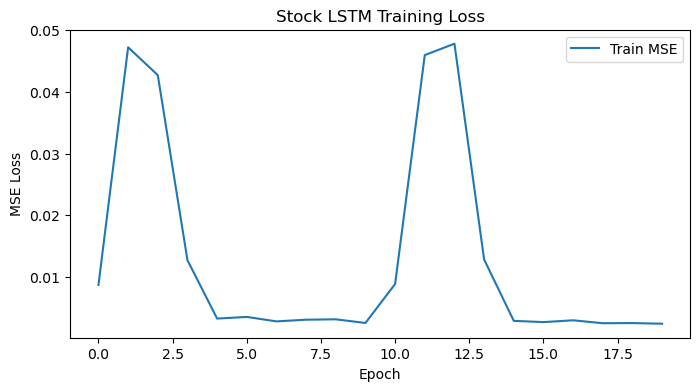

In [10]:
# 9. Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Stock LSTM Training Loss")
plt.legend()
plt.show()
